# PATHWAY ABUNDANCE (fr now this time please)

## step 1: get all the packages in

In [1]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import wesanderson
import re

## step 2: load all necessary data

In [2]:
# bowtie hit summaries for propionate
compiled_bt_hit_summaries_propionate = pd.read_csv("compiled_bt_hit_summaries_propionate.csv")

compiled_bt_hit_summaries_butyrate = pd.read_csv("compiled_bt_hit_summaries_butyrate.csv")

# total read counts for each SRA accession
readCountsDF = pd.read_csv("compiled_readCounts.csv")

# gene lengths 
propionate_gene_catalogue_seqlengths = pd.read_csv("propionate_gene_catalogue_seqlengths.csv")
butyrate_gene_catalogue_seqlengths = pd.read_csv("butyrate_gene_catalogue_seqlengths.csv")

## adding read count to df

### I think the `compiled_bt_hit_summaries_butyrate` given to me is wrong?? This is an attempt to fix that

In [3]:
compiled_bt_hit_summaries_butyrate = compiled_bt_hit_summaries_butyrate[compiled_bt_hit_summaries_butyrate.pathway != "propionate"]

### function to add read count + preprocess the data frames as required

In [4]:
def add_read_count(file, readCountsDF):
    return file.merge(readCountsDF, how="left", on="read_accession").drop(columns=['pathway']).set_index("read_accession").transpose()

### actually process the data frames

In [5]:
compiled_bt_hit_summaries_propionate = add_read_count(compiled_bt_hit_summaries_propionate, readCountsDF)

compiled_bt_hit_summaries_butyrate = add_read_count(compiled_bt_hit_summaries_butyrate, readCountsDF)

## gene length correction

### the function for gene length correction

In [6]:
def gene_length_correction(gene_catalogue_seqlengths, compiled_bt_hit_summaries, pathway): # change pathway name so that it makes more sense (make it clear that it's just for naming)

    gene_length_df = gene_catalogue_seqlengths.set_index("gene")

    df = compiled_bt_hit_summaries

    new = compiled_bt_hit_summaries.copy()

    # first replace the values in new with the gene length of that gene
    for gene in compiled_bt_hit_summaries.index:
        
        if gene in gene_length_df.index:
        
            gene_length = gene_length_df.loc[gene].at["length"]

            new.loc[gene] = [gene_length] * len(new.columns)

    # then divide what would have been reads_gene by the actual values
    new = df.div(new)

    # then divide by the total amount of reads
    for read in df:

        total_reads_for_sample = df[read].iat[-1]

        new[read] = df[read].div(total_reads_for_sample)

    new.to_csv("compiled_bt_hit_summaries_" + pathway + "_length_corrected")

    return new

### running the code for gene length correction

In [7]:
compiled_bt_hit_summaries_propionate_length_corrected = gene_length_correction(propionate_gene_catalogue_seqlengths, compiled_bt_hit_summaries_propionate, "propionate")

compiled_bt_hit_summaries_butyrate_length_corrected = gene_length_correction(butyrate_gene_catalogue_seqlengths, compiled_bt_hit_summaries_butyrate, "butyrate")

## useful setup for calculating pathway abundances

In [8]:
pathway_gene_lists = []
pathways = []
pathway_dict = {}
pathway_length_dict = {}

# loop through the entire directory of gene lists
for file in os.listdir("geneLists"):

    # create a filename in the form of "geneLists/filename"
    file_n = "geneLists/" + str(file)

    # get the actual pathway from the filename
    pathway = str(file).replace("_gene_list.txt", "")

    # get the list of genes in each file
    geneList = [line.rstrip() for line in open(file_n)]

    pathways.append(pathway)

    # this my way of bypassing that strange assign function from R
    pathway_dict[pathway] = geneList

    # pathway_length_dict[pathway + "_pathway_length"] = len(geneList)

    pathway_length_dict[pathway] = len(geneList)
    
    pathway_gene_lists.append(geneList)

# turn the gene pathways list of lists into a pandas dataframe, using `pathways` as the column names

gene_pathways_df = pd.DataFrame(pathway_gene_lists).transpose()

gene_pathways_df.columns = pathways

gene_pathways_df

,acetylCoA_buk,P3,P1_SP,aminobutyrate_buk,P1_WWC,lysine,glutarate,P2,acetylCoA_but,aminobutyrate_but
0,buk,fucO,methylmalonyl-CoA-mutase-EC5-4-99-2,buk,methylmalonyl-CoA-mutase-EC5-4-99-2,kal,hgdC,lcdA,but,but
1,hbd,pduP,methylmalonyl-CoA-epimerase-EC5-1-99-1,ptb,methylmalonyl-CoA-epimerase-EC5-1-99-1,kamA,hgdB,lcdB,hbd,abfD
2,ptb,pduC,methylmalonyl-CoA-decarboxylaseGamma-KOK23351,abfD,methylmalonyl-CoA-carboxyltransferase12S-KOK17489,kamD,hgdA,lcdC,thl,abfH
3,thl,pduD,methylmalonyl-CoA-decarboxylaseDelta-KOK23352,abfH,methylmalonyl-CoA-carboxyltransferase5S-KOK03416,kamE,gctA,acrC,bcd,abfT
4,bcd,pduE,methylmalonyl-CoA-decarboxylaseBeta-KOK20509,abfT,methylmalonyl-CoA-carboxyltransferase1-3S-KOK1...,kce,gctB,pct,cro,bcd
5,cro,pduL,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,bcd,None,kdd,gcdB,None,None,None
6,None,pduW,None,None,None,atoA,gcdA,None,None,None
7,None,None,None,None,None,atoD,but,None,None,None
8,None,None,None,None,None,bcd,buk,None,None,None
9,None,None,None,None,None,None,ptb,None,None,None


## calculating pathway abundances

### generate the dataframe to put everything in

In [9]:
# input: give a list of all dataframes that you wish to consider

def generate_final_df(gene_catalogues, columnNames):

    # get all the gene names from the gene catalogues
    index_list = []
    for catalogue in gene_catalogues:
        index_list += list(catalogue.gene)

    # return a final dataframe with all the gene names as the index, and the column names as specified
    # rename index of this dataframe to "gene_full_name"
    return pd.DataFrame(index = index_list, columns = columnNames)

### create the dataframe to put everything in, using the function `generate_final_df` 

In [10]:
colNames = ["gene_name_short", "overall_pathway", "prop_or_but"]

propionate_table_base = generate_final_df([propionate_gene_catalogue_seqlengths], colNames)

butyrate_table_base = generate_final_df([butyrate_gene_catalogue_seqlengths], colNames)

butyrate_table_base

,gene_name_short,overall_pathway,prop_or_but
4hbt%fig|1000568.3.peg.1292|HMPREF1039_0933|VBIMegSp189321_1292|,NaN,NaN,NaN
4hbt%fig|1000569.4.peg.840|HMPREF1040_1425|VBIMegSp187765_0840|,NaN,NaN,NaN
4hbt%fig|1002369.4.peg.3234|HMPREF9945_03357|VBICloDif188236_3234|,NaN,NaN,NaN
4hbt%fig|1009370.3.peg.814|ALO_04061|VBIAceLon187030_0814|,NaN,NaN,NaN
4hbt%fig|1030843.3.peg.1752|PGTDC60_1815|VBIPorGin195531_1752|,NaN,NaN,NaN
...,...,...,...
thl%fig|1459803.3.peg.1202|BA92_06220|,NaN,NaN,NaN
thl%fig|1520831.3.peg.847|IE90_04315|,NaN,NaN,NaN
thl%fig|1676991.3.peg.3161|,NaN,NaN,NaN
thl%fig|245018.3.peg.1292|CL2_10520|VBIButBac135163_1292|,NaN,NaN,NaN


### create the "short" gene names and add them to the table

#### the `short_names` functions just makes the list comprehension a little nicer to do 

`short_names_RC` is for making the short gene names when using a gene catalogue generated by RC

`short_names_Vital` is for making the short gene names when using a gene catalogue generated by Vital et. al.

In [11]:
def short_names_RC(df):

    df["gene_name_short"] = [gene.split("_")[-1] for gene in list(df.index.values)]

    return df

def short_names_Vital(df):

    # use regex to filter out only the letters within the short gene name
    df["gene_name_short"] = [re.sub(r'[^a-zA-Z]+', '', gene.split("%")[0]) for gene in list(df.index.values)]

    return df

#### now actually the short gene names onto the desired table(s)

In [12]:
propionate_table_base = short_names_RC(propionate_table_base)

propionate_table_base

,gene_name_short,overall_pathway,prop_or_but
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
...,...,...,...
Blautia-wexlerae-DSM-19850-MAF-2_pduW,pduW,NaN,NaN
Enterocloster-asparagiformis-DSM-15981-MAF-2_pduW,pduW,NaN,NaN
Enterocloster-bolteae-ATCC-BAA-613-MAF-2_pduW,pduW,NaN,NaN
Roseburia-inulinivorans-strain-AF28-15_pduW,pduW,NaN,NaN


In [13]:
butyrate_table_base = short_names_Vital(butyrate_table_base)

butyrate_table_base

,gene_name_short,overall_pathway,prop_or_but
4hbt%fig|1000568.3.peg.1292|HMPREF1039_0933|VBIMegSp189321_1292|,hbt,NaN,NaN
4hbt%fig|1000569.4.peg.840|HMPREF1040_1425|VBIMegSp187765_0840|,hbt,NaN,NaN
4hbt%fig|1002369.4.peg.3234|HMPREF9945_03357|VBICloDif188236_3234|,hbt,NaN,NaN
4hbt%fig|1009370.3.peg.814|ALO_04061|VBIAceLon187030_0814|,hbt,NaN,NaN
4hbt%fig|1030843.3.peg.1752|PGTDC60_1815|VBIPorGin195531_1752|,hbt,NaN,NaN
...,...,...,...
thl%fig|1459803.3.peg.1202|BA92_06220|,thl,NaN,NaN
thl%fig|1520831.3.peg.847|IE90_04315|,thl,NaN,NaN
thl%fig|1676991.3.peg.3161|,thl,NaN,NaN
thl%fig|245018.3.peg.1292|CL2_10520|VBIButBac135163_1292|,thl,NaN,NaN


### `get_overall_pathway` gets the correct overall pathways given a dataframe with gene_name_short propigated already

In [14]:
def get_overall_pathway(df, gene_pathways_df):

    overall_pathway_list = []

    genes_with_duplicates = ["methylmalonyl-CoA-mutase-EC5-4-99-2", "methylmalonyl-CoA-epimerase-EC5-1-99-1", "buk", "but"]

    result = ""

    for gene in list(df.gene_name_short):

        modified = False

        for pathway_name in gene_pathways_df:

            if gene in set(gene_pathways_df[pathway_name]):

                if gene not in genes_with_duplicates:

                    overall_pathway_list.append(pathway_name) 

                    modified = True

                    break

                else:

                    if gene == "buk":

                        overall_pathway_list.append("acetylCoA_buk/aminobutyrate_buk")

                        modified = True

                        break

                    if gene == "but":
                        
                        overall_pathway_list.append("acetylCoA_but/aminobutyrate_but")

                        modified = True

                        break


                    if gene == "methylmalonyl-CoA-mutase-EC5-4-99-2" or "methylmalonyl-CoA-epimerase-EC5-1-99-1":
                        
                        overall_pathway_list.append("P1_SP/P1_WWC")

                        modified = True

                        break


        if not modified: overall_pathway_list.append(None)

    df["overall_pathway"] = overall_pathway_list

    return df


### actually get the overall pathways using the function defined above

In [15]:
propionate_table_base = get_overall_pathway(propionate_table_base, gene_pathways_df=gene_pathways_df)

butyrate_table_base = get_overall_pathway(butyrate_table_base, gene_pathways_df=gene_pathways_df)


### find out if this pathway does propionate or butyrate

In [16]:
def find_pathway(df):

    prop_pathways = ["P1_SP", "P1_WWC", "P1_SP/P1_WWC", "P2", "P3"]

    butyrate_pathways = ["acetylCoA_buk", "aminobutyrate_buk", "lysine", "glutarate", "acetylCoA_but", "aminobutyrate_bu"]

    pathway_result = []

    for path in df["overall_pathway"]:

        pathway_result.append("prop") if path in prop_pathways else pathway_result.append("but")
        
    df["prop_or_but"] = pathway_result

    return df

In [17]:
propionate_table_base = find_pathway(propionate_table_base)

butyrate_table_base = find_pathway(butyrate_table_base)

### finally: pathway abundance time!

#### merge the useful information onto the normalized hit table

In [18]:
propionate_table_base = propionate_table_base.merge(compiled_bt_hit_summaries_propionate_length_corrected, how = "left", left_index=True, right_index=True)

butyrate_table_base = butyrate_table_base.merge(compiled_bt_hit_summaries_butyrate_length_corrected, how = "left", left_index=True, right_index=True)

prop_but_final = pd.concat([propionate_table_base, butyrate_table_base])

# prop_but_final = prop_but_final.merge(compiled_bt_hit_summaries_butyrate_length_corrected, how = "left", left_index=True, right_index=True)

# summed_propionate = compiled_bt_hit_summaries_propionate_length_corrected.sum(axis=1)

# summed_propionate.name = "pathway_abundance"

# propionate_final_test = propionate_final_test.merge(summed_propionate, how = "left", left_index=True, right_index=True)

prop_but_final

,gene_name_short,overall_pathway,prop_or_but,ERR525688,ERR525689,ERR525690,ERR525691,ERR525692,ERR525693,ERR525694,...,ERR525825,ERR525842,ERR525883,ERR525888,ERR525930,ERR525934,ERR525942,ERR525970,ERR526030,ERR526062
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,NaN,NaN,NaN,NaN,1.251230e-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,3.727259e-06,5.429660e-05,6.213023e-08,NaN,1.251230e-06,4.657935e-08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,NaN,2.591723e-08,NaN,2.471279e-08,1.049501e-05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,1.150389e-07,1.295862e-07,NaN,NaN,4.085648e-07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,NaN,NaN,NaN,NaN,2.400318e-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
thl%fig|1459803.3.peg.1202|BA92_06220|,thl,acetylCoA_buk,but,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thl%fig|1520831.3.peg.847|IE90_04315|,thl,acetylCoA_buk,but,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thl%fig|1676991.3.peg.3161|,thl,acetylCoA_buk,but,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thl%fig|245018.3.peg.1292|CL2_10520|VBIButBac135163_1292|,thl,acetylCoA_buk,but,6.212099e-07,6.479308e-07,NaN,NaN,7.660591e-08,NaN,1.676198e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,2.907520e-08,NaN,NaN,NaN


## playing around with groupby to see what I get

In [19]:
gene_short_groupby = prop_but_final.groupby(["gene_name_short", "overall_pathway"]).sum()

gene_short_groupby

,,prop_or_but,ERR525688,ERR525689,ERR525690,ERR525691,ERR525692,ERR525693,ERR525694,ERR525695,ERR525697,...,ERR525825,ERR525842,ERR525883,ERR525888,ERR525930,ERR525934,ERR525942,ERR525970,ERR526030,ERR526062
gene_name_short,overall_pathway,,,,,,,,,,,,,,,,,,,,,
abfD,aminobutyrate_buk,butbutbutbutbutbutbutbutbutbutbutbutbutbutbutb...,5.521866e-06,1.228477e-05,0.000000e+00,0.000000e+00,1.412102e-05,0.000000e+00,4.923833e-06,1.992886e-07,7.371438e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.200159e-08,0.000000e+00
abfH,aminobutyrate_buk,butbutbutbutbutbutbutbutbutbutbutbutbutbutbutb...,3.267104e-06,1.863449e-05,3.106512e-08,0.000000e+00,1.218034e-05,0.000000e+00,6.306697e-06,1.138792e-07,4.131484e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
acrC,P2,propproppropprop,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.107061e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.304679e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
atoA,lysine,butbutbutbutbutbutbutbutbutbutbutbutbutbutbutb...,2.300777e-08,1.295862e-07,0.000000e+00,0.000000e+00,1.184838e-05,0.000000e+00,0.000000e+00,1.138792e-07,8.719606e-06,...,0.000000e+00,5.721727e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.815040e-08,0.000000e+00,0.000000e+00,0.000000e+00
atoD,lysine,butbutbutbutbutbutbutbutbutbutbutbutbutbutbutb...,0.000000e+00,1.814206e-07,0.000000e+00,0.000000e+00,1.049501e-05,0.000000e+00,0.000000e+00,8.540938e-08,6.806077e-06,...,0.000000e+00,0.000000e+00,2.685597e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bcd,acetylCoA_buk,butbutbutbutbutbutbutbutbutbutbutbutbutbutbutb...,9.207711e-05,1.147615e-04,1.646451e-06,1.804034e-06,6.381272e-05,2.561864e-07,6.591650e-05,1.076158e-05,9.535031e-05,...,6.865363e-08,0.000000e+00,1.879918e-07,8.011897e-04,2.855896e-08,1.113481e-07,2.907520e-08,3.746806e-08,6.355123e-05,3.039345e-07
buk,acetylCoA_buk/aminobutyrate_buk,butbutbutbutbutbutbutbutbutbutbutbutbutbutbutb...,2.530855e-07,2.140763e-05,5.591721e-07,2.051162e-06,2.400318e-06,6.986903e-08,2.996205e-06,3.957301e-06,1.313377e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,1.538207e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.034059e-05,0.000000e+00
but,acetylCoA_but/aminobutyrate_but,butbutbutbutbutbutbutbutbutbutbutbutbutbutbutb...,8.190768e-05,5.823602e-05,0.000000e+00,0.000000e+00,1.131214e-05,1.630277e-07,4.303639e-05,1.138792e-07,5.905848e-05,...,6.865363e-08,1.144345e-06,5.371195e-08,1.762987e-07,1.427948e-07,4.453926e-08,0.000000e+00,0.000000e+00,0.000000e+00,4.341921e-08
cro,acetylCoA_buk,butbutbutbutbutbutbutbutbutbutbutbutbutbutbutb...,5.751944e-05,6.738480e-05,2.795860e-07,1.334491e-06,1.585742e-05,3.260555e-07,3.193158e-05,5.181502e-06,4.207591e-05,...,0.000000e+00,1.144345e-06,8.056792e-08,4.344222e-04,0.000000e+00,4.453926e-08,0.000000e+00,0.000000e+00,3.854075e-05,1.302576e-07


In [20]:
useful_display = prop_but_final.groupby([ "prop_or_but", "overall_pathway", "gene_name_short"]).sum()

# for pathway in list(overall_pathway_groupby.index.values):
   
#     if pathway in pathway_length_dict.keys():

#         overall_pathway_groupby.at[pathway, "pathway_abundance"] /= pathway_length_dict[pathway]

# overall_pathway_groupby.at['P1_SP/P1_WCC', "pathway_abundance"] /= 5.5

useful_display

ERR525688  \
prop_or_but overall_pathway                 gene_name_short                                                    
but         acetylCoA_buk                   bcd                                                 9.207711e-05   
                                            cro                                                 5.751944e-05   
                                            ptb                                                 6.672254e-07   
                                            thl                                                 9.423984e-05   
            acetylCoA_buk/aminobutyrate_buk buk                                                 2.530855e-07   
            acetylCoA_but/aminobutyrate_but but                                                 8.190768e-05   
            aminobutyrate_buk               abfD                                                5.521866e-06   
                                            abfH                                                3.267104e-06   
            glutarate                       gcdA                                                2.346793e-06   
                                            gcdB                                                1.265428e-06   
                                            gctA                                                1.127381e-06   
                                            gctB                                                6.672254e-07   
            lysine                          atoA                                                2.300777e-08   
                                            atoD                                                0.000000e+00   
                                            kal                                                 2.070700e-07   
                                            kamA                                                4.601555e-07   
                                            kamD                                                8.052721e-07   
                                            kamE                                                3.681244e-07   
                                            kce                                                 9.433187e-07   
                                            kdd                                                 1.357459e-06   
prop        P1_SP                           methylmalonyl-CoA-decarboxylaseAlpha-KOK01604       3.616822e-05   
                                            methylmalonyl-CoA-decarboxylaseBeta-KOK20509        2.404312e-05   
                                            methylmalonyl-CoA-decarboxylaseDelta-KOK23352       3.313119e-06   
                                            methylmalonyl-CoA-decarboxylaseGamma-KOK23351       4.946671e-06   
            P1_SP/P1_WWC                    methylmalonyl-CoA-epimerase-EC5-1-99-1              4.923664e-06   
                                            methylmalonyl-CoA-mutase-EC5-4-99-2                 7.357886e-05   
            P1_WWC                          methylmalonyl-CoA-carboxyltransferase1-3S-KOK17490  0.000000e+00   
                                            methylmalonyl-CoA-carboxyltransferase12S-KOK17489   0.000000e+00   
                                            methylmalonyl-CoA-carboxyltransferase5S-KOK03416    0.000000e+00   
            P2                              acrC                                                0.000000e+00   
                                            lcdA                                                0.000000e+00   
                                            lcdB                                                0.000000e+00   
                                            lcdC                                                0.000000e+00   
                                            pct                                                 0.000000e+00   
            P3                              fucO                   

### normalisation with respect to the length of each pathway

In [23]:
overall_pathway_group = prop_but_final.groupby(["overall_pathway"]).sum()

overall_pathway_group = overall_pathway_group.drop(["gene_name_short", "prop_or_but"], axis=1)

for pathway in list(overall_pathway_group.index.values):
   
    if pathway in pathway_length_dict.keys():

        overall_pathway_group.loc[pathway] /= pathway_length_dict[pathway]

overall_pathway_group.loc['P1_SP/P1_WWC'] /= 5.5

overall_pathway_group.loc["acetylCoA_buk/aminobutyrate_buk"] /= 6

overall_pathway_group.loc["acetylCoA_but/aminobutyrate_but"] /= 5

overall_pathway_group

,ERR525688,ERR525689,ERR525690,ERR525691,ERR525692,ERR525693,ERR525694,ERR525695,ERR525697,ERR525698,...,ERR525825,ERR525842,ERR525883,ERR525888,ERR525930,ERR525934,ERR525942,ERR525970,ERR526030,ERR526062
overall_pathway,,,,,,,,,,,,,,,,,,,,,
P1_SP,1.141186e-05,1.889798e-05,6.057698e-07,1.276828e-07,1.164410e-05,2.236973e-05,1.555722e-05,2.633456e-06,8.407933e-06,2.353891e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
P1_SP/P1_WWC,1.427319e-05,1.428275e-05,7.286182e-07,6.290529e-08,1.183445e-05,2.210826e-05,2.020581e-05,3.002269e-06,9.168337e-06,2.698405e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
P1_WWC,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
P2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.617767e-08,0.000000e+00,0.000000e+00,0.000000e+00,2.261444e-07,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
P3,1.472498e-06,4.927976e-06,2.795860e-07,1.659288e-07,3.757337e-07,4.691206e-07,4.070768e-07,3.176415e-06,1.304679e-07,4.290984e-09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
acetylCoA_buk,4.075060e-05,5.546719e-05,7.818054e-07,1.033819e-06,1.773852e-05,1.358565e-07,2.603346e-05,4.237254e-06,3.612874e-05,4.305288e-07,...,4.004795e-08,1.907242e-07,5.818795e-08,3.446641e-04,5.235809e-08,5.196246e-08,9.691733e-09,1.248935e-08,2.796254e-05,8.683843e-08
acetylCoA_buk/aminobutyrate_buk,4.218092e-08,3.567939e-06,9.319535e-08,3.418603e-07,4.000531e-07,1.164484e-08,4.993675e-07,6.595502e-07,2.188962e-06,7.509223e-08,...,0.000000e+00,0.000000e+00,0.000000e+00,2.563678e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.056765e-06,0.000000e+00
acetylCoA_but/aminobutyrate_but,1.638154e-05,1.164720e-05,0.000000e+00,0.000000e+00,2.262428e-06,3.260555e-08,8.607279e-06,2.277583e-08,1.181170e-05,3.003689e-08,...,1.373073e-08,2.288691e-07,1.074239e-08,3.525975e-08,2.855896e-08,8.907851e-09,0.000000e+00,0.000000e+00,0.000000e+00,8.683843e-09
aminobutyrate_buk,1.464828e-06,5.153209e-06,5.177519e-09,0.000000e+00,4.383560e-06,0.000000e+00,1.871755e-06,5.219462e-08,1.917154e-06,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.366693e-08,0.000000e+00


In [24]:
# prop_but_groupby = prop_but_final.groupby(["prop_or_but"]).sum()

# prop_but_groupby

prop_but_final

,gene_name_short,overall_pathway,prop_or_but,ERR525688,ERR525689,ERR525690,ERR525691,ERR525692,ERR525693,ERR525694,...,ERR525825,ERR525842,ERR525883,ERR525888,ERR525930,ERR525934,ERR525942,ERR525970,ERR526030,ERR526062
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,NaN,NaN,NaN,NaN,1.251230e-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,3.727259e-06,5.429660e-05,6.213023e-08,NaN,1.251230e-06,4.657935e-08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,NaN,2.591723e-08,NaN,2.471279e-08,1.049501e-05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,1.150389e-07,1.295862e-07,NaN,NaN,4.085648e-07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,prop,NaN,NaN,NaN,NaN,2.400318e-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
thl%fig|1459803.3.peg.1202|BA92_06220|,thl,acetylCoA_buk,but,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thl%fig|1520831.3.peg.847|IE90_04315|,thl,acetylCoA_buk,but,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thl%fig|1676991.3.peg.3161|,thl,acetylCoA_buk,but,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thl%fig|245018.3.peg.1292|CL2_10520|VBIButBac135163_1292|,thl,acetylCoA_buk,but,6.212099e-07,6.479308e-07,NaN,NaN,7.660591e-08,NaN,1.676198e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,2.907520e-08,NaN,NaN,NaN


## random plots testing time

In [ ]:
# ax.bar(list(propionate_final_test.index.values), list(propionate_final_test.pathway_abundance))

# numberOfBars = len(propionate_final_hit_table)

# temp_table = propionate_final_hit_table.drop(["gene_name_short", "overall_pathway"], axis=1)

# temp_table.plot(kind="bar", stacked=True, color = wesanderson.film_palette('Zissou'))

# plt.title("just plotting the raw data from propionate", fontsize = 16)

# plt.xlabel("samples")

# plt.ylabel("pathway abundance")

# # plt.bar(list(propionate_final_hit_table.index.values), list(propionate_final_hit_table.pathway_abundance), color=wesanderson.film_palette('Zissou'))

# # ax.set(xlabel="gene", ylabel="pathway abundance", title="propionate_final_hit_table")

# plt.show()

In [ ]:
# fig, ax = plt.subplots()

# gene_short_plotting_table = gene_short_groupby.drop(["overall_pathway"], axis=1)

# sns.set_style("whitegrid")

# gene_short_plotting_table.plot(kind="bar", stacked=True, y=  color = wesanderson.film_palette('Zissou'))

# # ax.bar(list(gene_short_groupby.index.values), list(gene_short_groupby.pathway_abundance), color = wesanderson.film_palette('Zissou'))

# # ax.set(xlabel="gene", ylabel="pathway abundance", title="gene_short_groupby")

# plt.show()

In [31]:
def stackedBarDF(overall_pathway_df):

    temp_table = overall_pathway_df.transpose()

    temp_dict = {}

    for column in temp_table:

        temp_dict[column] = temp_table[column].tolist()

    samples_list = list(temp_table.index.values)

    plottingDF = pd.DataFrame(
        temp_dict,
        index = samples_list
    )

    return plottingDF

def plotStackedBar(stackedBarDF):
    n = len(stackedBarDF.columns)
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    return stackedBarDF.plot.bar(stacked=True, color=colors, figsize=(20,6)).set(xlabel="sample", ylabel="pathway abundance", title="overall pathway groupby", xticks=([]))

def sortedStackedBar(df, sortBy):
    return plotStackedBar(stackedBarDF(df).sort_values(by=sortBy))


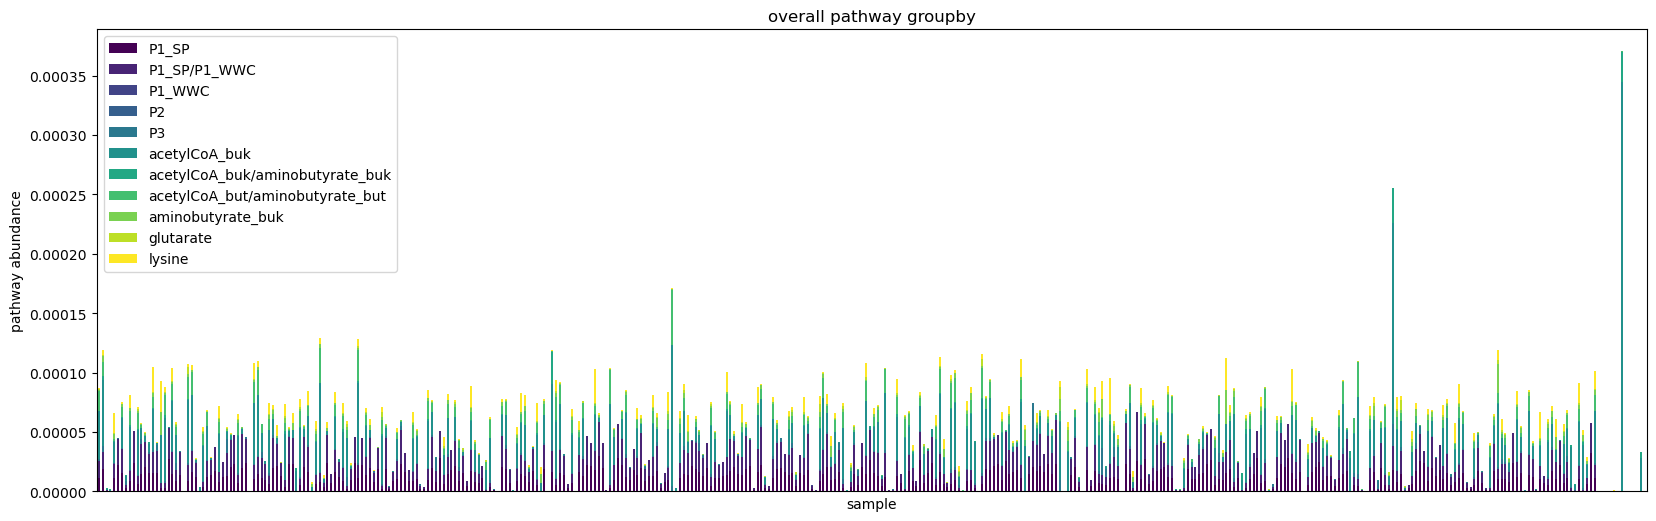

In [29]:
unsorted_final_graph = plotStackedBar(stackedBarDF(overall_pathway_group))

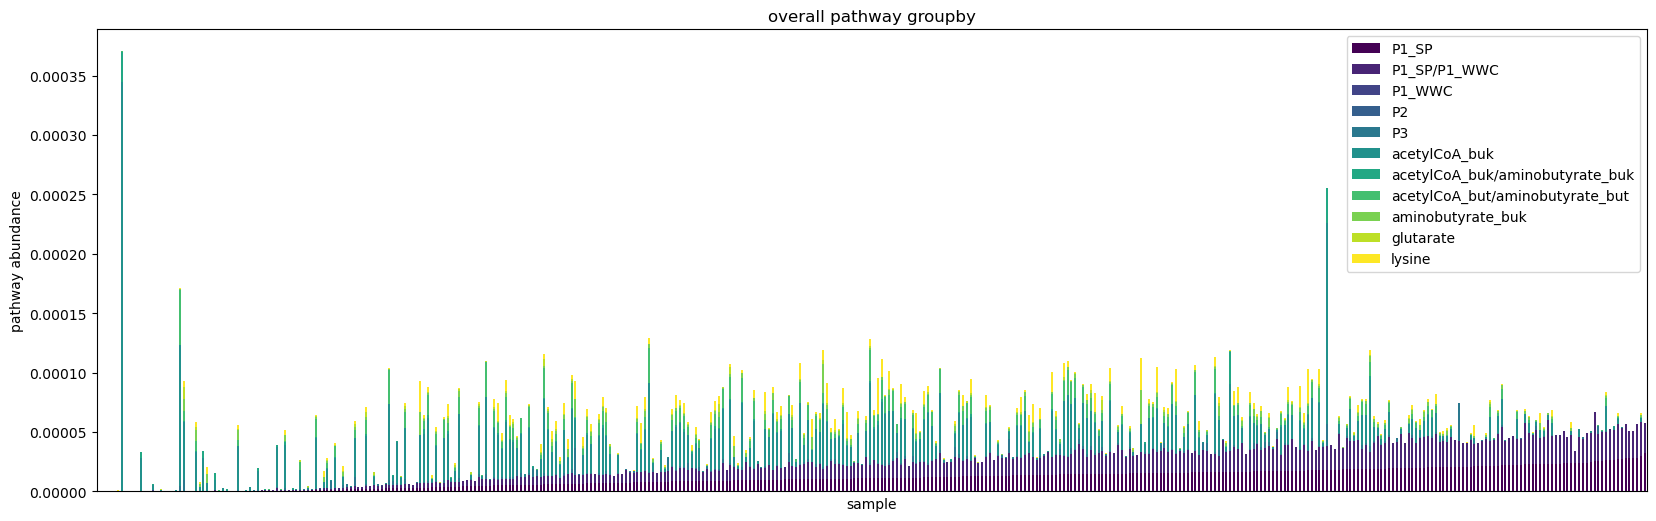

In [35]:
sortByP1_SPGraph = sortedStackedBar(overall_pathway_group, "P1_SP")

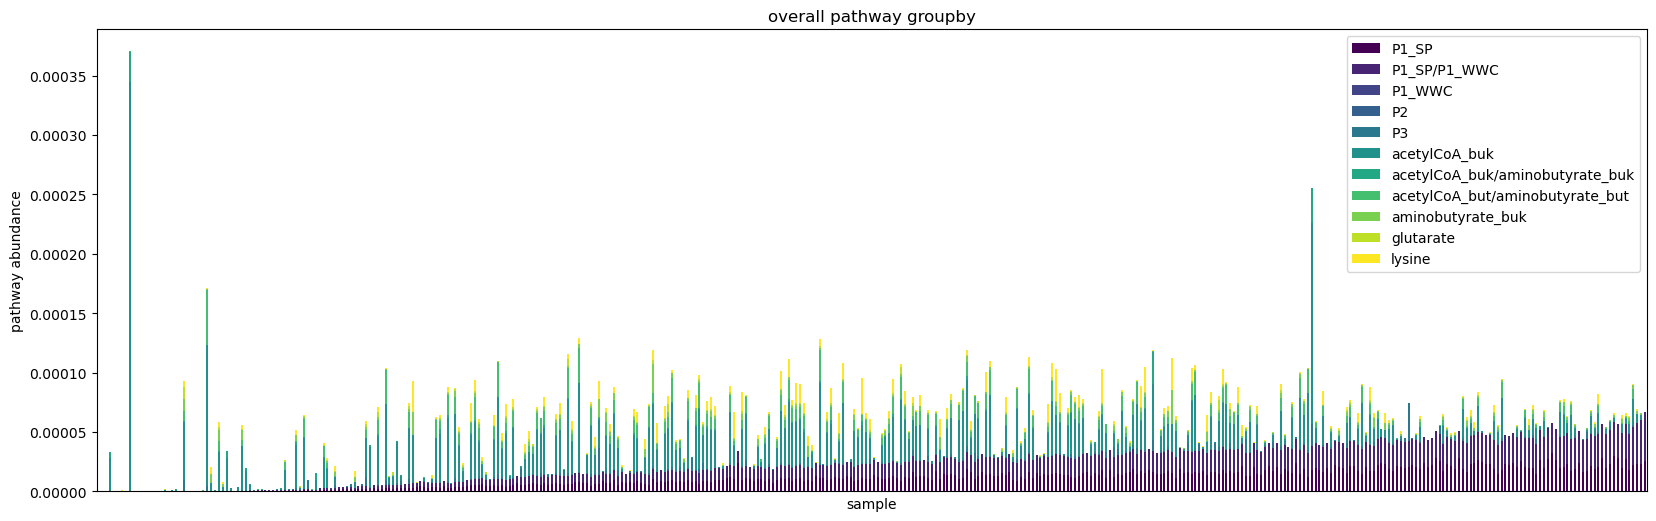

In [36]:
sort_P1_SP_P1_WWC_graph = sortedStackedBar(overall_pathway_group, "P1_SP/P1_WWC")

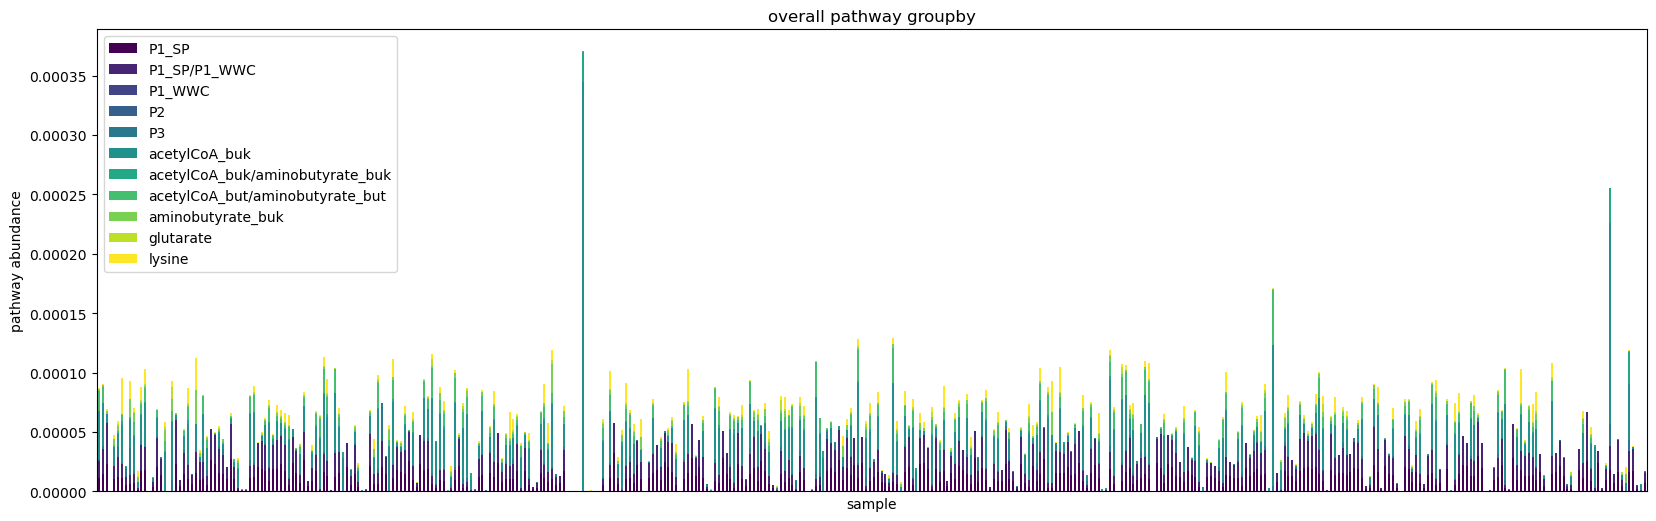

In [37]:
sort_P1_WWC_graph = sortedStackedBar(overall_pathway_group, "P1_WWC")

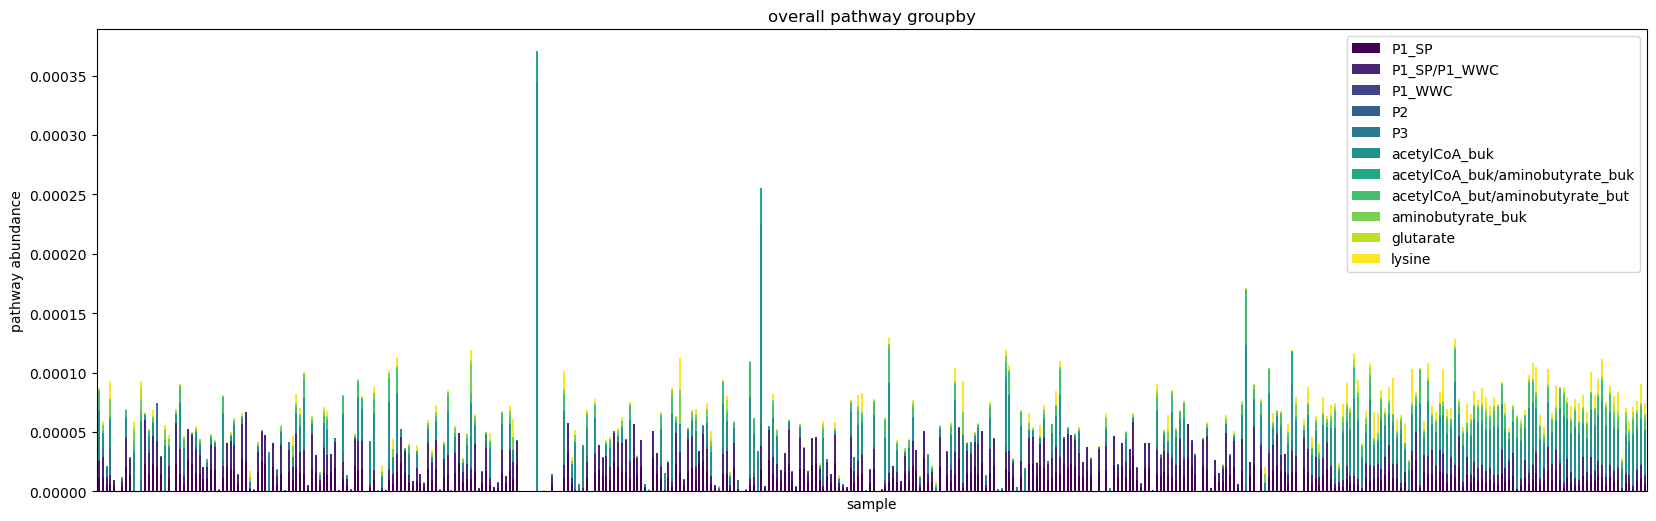

In [38]:
sort_P2_graph = sortedStackedBar(overall_pathway_group, "P2")

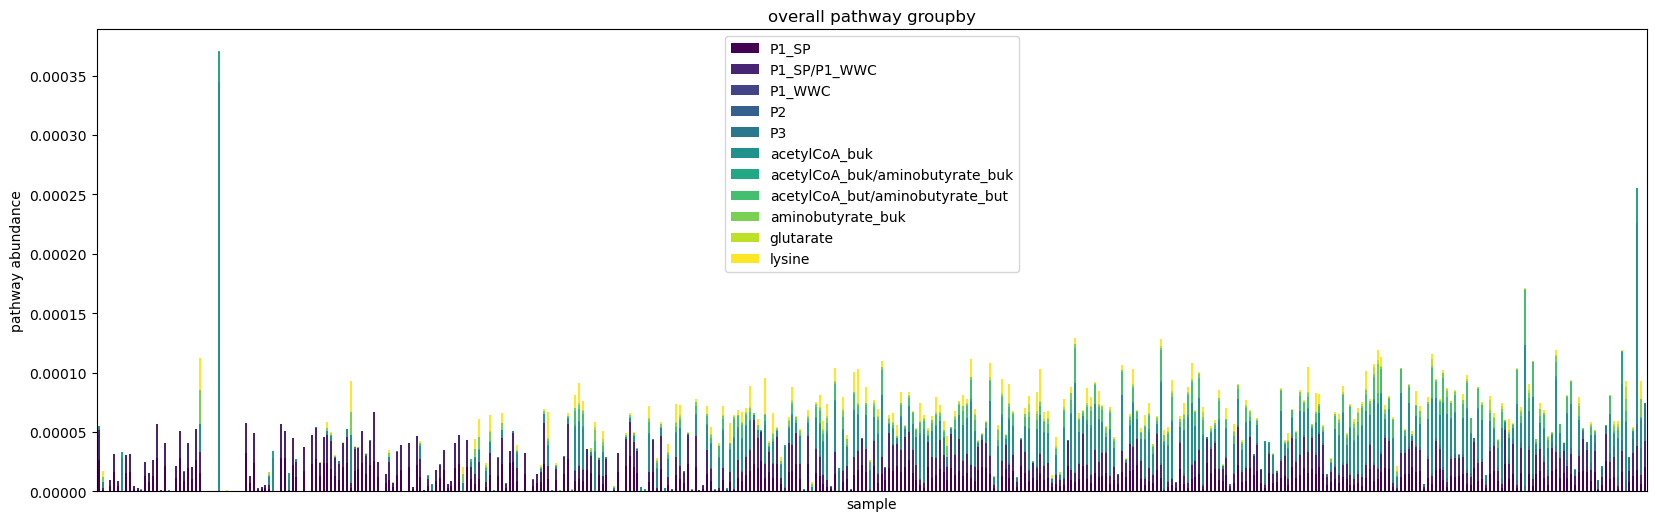

In [39]:
sort_P3_graph = sortedStackedBar(overall_pathway_group, "P3")

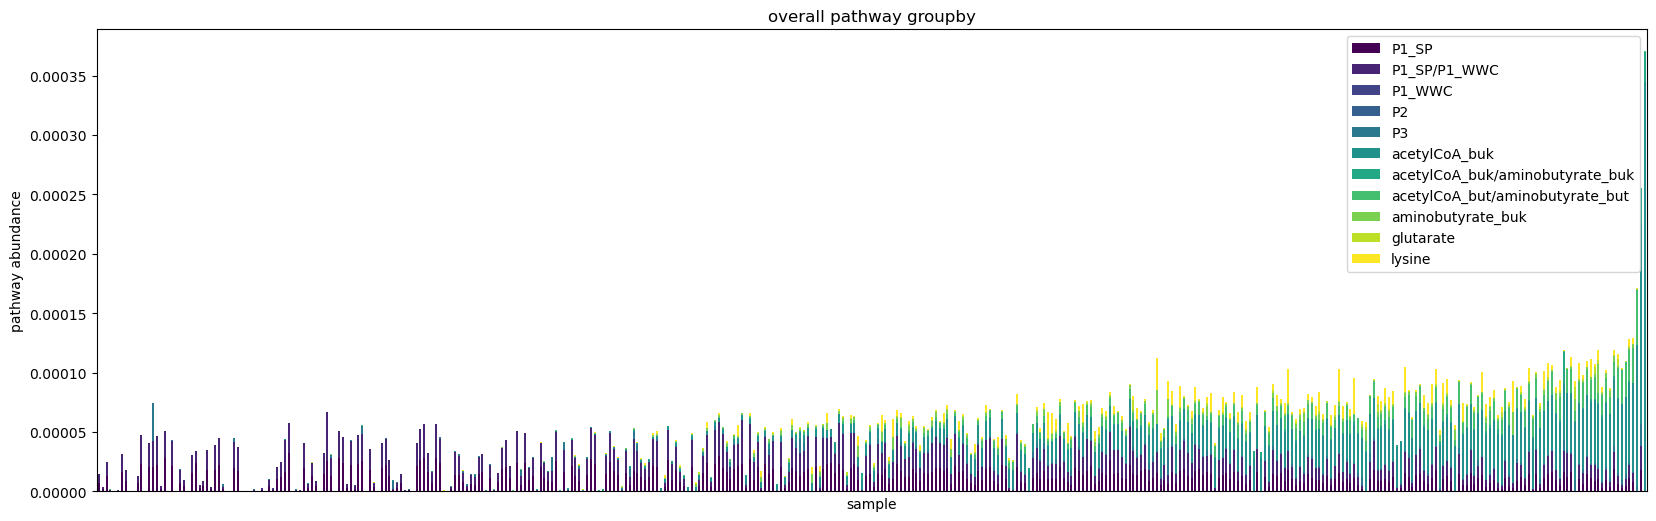

In [41]:
sort_acetylCoA_buk_graph = sortedStackedBar(overall_pathway_group, "acetylCoA_buk")

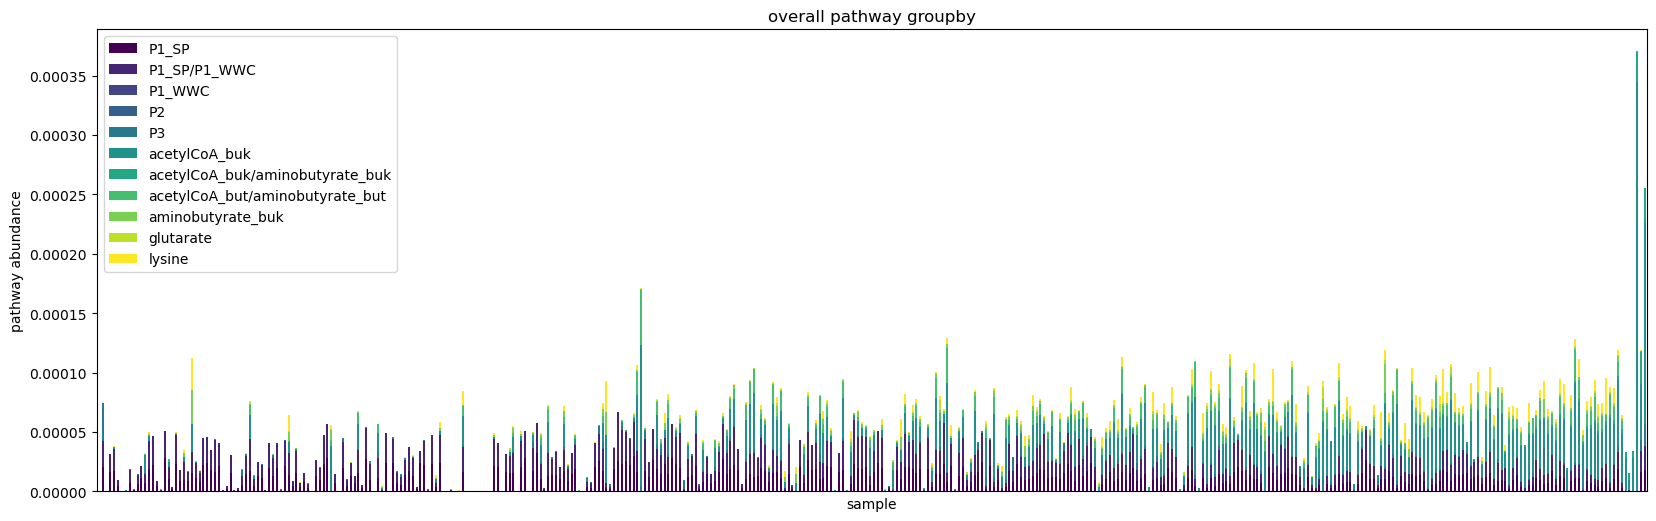

In [42]:
sort_acetylCoA_buk_aminobutyrate_buk_graph = sortedStackedBar(overall_pathway_group, "acetylCoA_buk/aminobutyrate_buk")

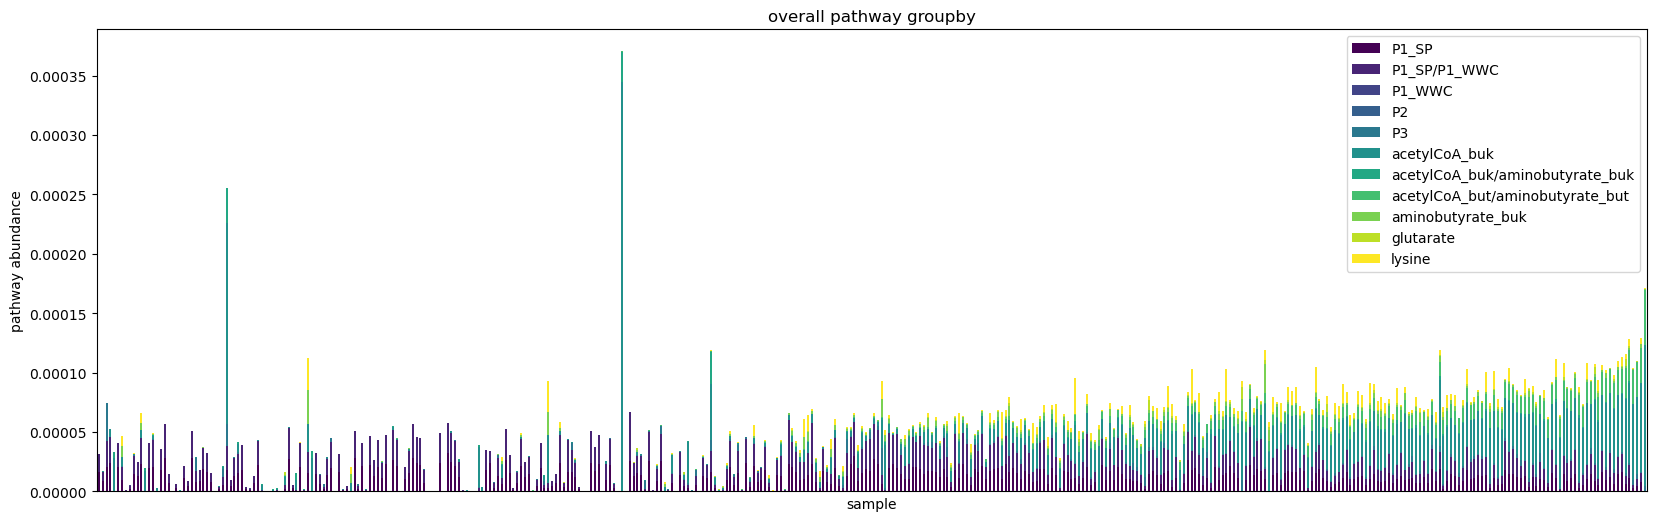

In [43]:
sort_acetylCoA_but_aminobutyrate_but_graph = sortedStackedBar(overall_pathway_group, "acetylCoA_but/aminobutyrate_but")